# Iterative adversarial training with the HSJA attack and a Random Forest model using CICIDS2017 dataset

In this notebook we implement iterative adversarial training with the HopSkipJump attack, which is a powerful black-box evasion attack, and two non-differentiable models, a Random Forest model and a Decision Tree model, using CICIDS2017 dataset.

We conduct two experiments:
* Iterative adversarial training with the HopSkipJump attack and the Random Forest model. The hypothesis here is that adversarial training in this case would be able to increase robustness against repeated adversarial attacks. This hypothesis is disproved by the results of this experiment.
* Iterative adversarial training with the HopSkipJump attack and the Decision Tree model. The aim of the second experiment is to explain the results of the first experiment.

Training data: https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/web_attacks_balanced.zip

Training dataset is the balanced dataset based on CICIDS2017: https://www.unb.ca/cic/datasets/ids-2017.html

Sources:

* J. Chen, M. I. Jordan and M. J. Wainwright, "HopSkipJumpAttack: A Query-Efficient Decision-Based Attack," 2020 IEEE Symposium on Security and Privacy (SP), San Francisco, CA, USA, 2020, pp. 1277-1294, doi: 10.1109/SP40000.2020.00045.

In [1]:
import json
import math
import pickle
import time
import warnings

from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import HopSkipJump, ZooAttack
from graphviz import Source
from IPython.display import display_svg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
%matplotlib inline
warnings.filterwarnings('ignore')

## The training algorithm

First, we define a classifier class that enables us to use the same training code with Random Forest and Decision Tree classifiers. It provides the needed functionality:
* creating, fitting, saving, loading the model;
* predicting labels;
* generating adversarial samples for the original samples;
* displaying the decision tree (for Decision Tree models).

The key function here is <i>generate_hsja_samples</i> that produces adversarial samples for the given original samples using the HopSkipJump attack (https://arxiv.org/abs/1904.02144).

We use the untargeted l<sub>2</sub> version of HSJA implemented in the Adversarial Robustness Toolbox library (https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#hopskipjump-attack).

In [2]:
class Classifier:
    def __init__(self, model_type='RF'):
        # Create a Random Forest model.
        if model_type == 'RF':
            self._model = RandomForestClassifier(
                n_estimators=10, criterion='gini', max_depth=None,
                min_samples_split=2, min_samples_leaf=1,
                min_weight_fraction_leaf=0.0, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                bootstrap=True, oob_score=False, n_jobs=None,
                random_state=None, verbose=0, warm_start=False,
                class_weight=None)
        # Create a Decision Tree model.
        elif model_type == 'DT':
            self._model = DecisionTreeClassifier(
                criterion='gini', splitter='best', max_depth=None,
                min_samples_split=2, min_samples_leaf=1,
                min_weight_fraction_leaf=0.0, max_features='sqrt',
                random_state=None, max_leaf_nodes=5,
                min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)
        else:
            self._model = None

    def fit(self, X, y):
        return self._model.fit(X=X, y=y)

    def predict(self, X):
        return self._model.predict(X)

    def save_model(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self._model, f)

    def load_model(self, path):
        self._model = pickle.load(open(path, 'rb'))

    def generate_hsja_samples(self, X_test):
        # Create ART classifier for a scikit-learn classifier.
        art_classifier = SklearnClassifier(
            model=self._model, preprocessing=(0.0, 1.0))

        # Create ART HopSkipJump attack.
        hsja = HopSkipJump(classifier=art_classifier, batch_size=64,
                           targeted=False, norm=2, max_iter=50,
                           max_eval=10000, init_eval=100,
                           init_size=100, verbose=True)

        # Generate adversarial samples with ART HopSkipJump attack.
        start_time = time.time()
        X_test_adv = hsja.generate(X_test)
        generation_time = time.time() - start_time

        return X_test_adv, generation_time

    def display_tree(self, features=None):
        # Show the tree as a text.
        print(export_text(self._model, feature_names=features))
        # Show the tree as a picture.
        display_svg(Source(export_graphviz(self._model,
                                           feature_names=features)))

We use the following function to get evaluation metrics.

In [3]:
def get_metrics(y_eval, y_pred, average='weighted'):
    accuracy = accuracy_score(y_eval, y_pred)
    precision = precision_score(y_eval, y_pred, average=average)
    recall = recall_score(y_eval, y_pred, average=average)
    f1 = f1_score(y_eval, y_pred, average=average)

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}

Next, we define a function that retrains a model using the crafted adversarial samples. This step is performed on each iteration of adversarial training.

In [4]:
def retrain_model(model, X_test_adv, X_test_defence, X_defence, y_defence):
    # Extend the current dataset with adversarial samples using the correct labels.
    for i in range(X_test_defence.shape[0]):
        if model.predict(X_test_defence[[i]]) != model.predict(X_test_adv[[i]]):
            X_defence = np.vstack([X_defence, X_test_adv[i]])
            y_defence = np.append(
                y_defence, model.predict(X_test_defence[[i]]))

    # Split the current dataset into train and test sets.
    X_train, X_test, y_train, y_test = train_test_split(
        X_defence, y_defence, test_size=0.25, shuffle=True, random_state=42)

    # Create and fit a new model.
    model = Classifier(model_type)
    model.fit(X=X_train, y=y_train)

    return model, X_defence, y_defence, X_test, y_test

Finally, we define the iterative adversarial training algorithm that performs adversarial training of the given model for the given number of iterations using HSJA.

In [5]:
def adversarial_training(original_model, X, y, X_test, y_test, iterations=10):
    model = original_model
    X_defence = X
    y_defence = y
    X_test_defence = X_test
    y_test_defence = y_test
    results = []

    for iteration in range(iterations):
        iteration_results = {}

        # Generate the HSJA samples.
        X_test_adv, generation_time = model.generate_hsja_samples(
            X_test_defence)
        iteration_results['generation_time'] = generation_time

        # Get model metrics after the attack.
        y_pred_adv = model.predict(X_test_adv)
        matrix = confusion_matrix(y_test_defence, y_pred_adv)
        iteration_results['matrix_attacked'] = matrix
        iteration_results['metrics_attacked'] = get_metrics(
            y_test_defence, y_pred_adv)

        # Get samples' info.
        count = 0
        for i in range(0, X_test_defence.shape[0]):
            if model.predict(X_test_defence[[i]])[0] != y_pred_adv[i]:
                if not count:
                    iteration_results['sample_id'] = i
                    iteration_results['original_sample'] = X_test_defence[[i]]
                    pred = model.predict(X_test_defence[[i]])
                    iteration_results['original_prediction'] = pred[0]
                    iteration_results['adversarial_sample'] = X_test_adv[[i]]
                    pred_adv = model.predict(X_test_adv[[i]])
                    iteration_results['adversarial_prediction'] = pred_adv[0]
                count += 1
                
        iteration_results['count'] = count
        iteration_results['x_len'] = X_defence.shape[0]
        iteration_results['x_test_len'] = X_test_defence.shape[0]

        # Retrain the model with adversarial samples.
        model, X_defence, y_defence, X_test_defence, y_test_defence = retrain_model(
            model, X_test_adv, X_test_defence, X_defence, y_defence)
    
        iteration_results['x_len_adv'] = X_defence.shape[0]
        iteration_results['x_test_len_adv'] = X_test_defence.shape[0]
        
        if model_type == 'DT':
            print(f'DT after adversarial training (iteration {iteration + 1}):')
            model.display_tree(features=webattack_features)

        # Get model metrics after adversarial training.
        y_pred_adv = model.predict(X_test_defence)
        matrix = confusion_matrix(y_test_defence, y_pred_adv)
        iteration_results['matrix_retrained'] = matrix
        iteration_results['metrics_retrained'] = get_metrics(
            y_test_defence, y_pred_adv)

        results.append(iteration_results)

    # Save final retrained model.
    model.save_model(f'model_{model_type}_final.sav')

    return results

We use the following function to generate reports on experiments' results.

In [6]:
def print_training_results(results):
    for i, result in enumerate(results):
        print(f'\n====ITERATION NO. {i + 1}====\n')
        print(f'Before adversarial training:'
              f' {result["x_len"]} samples in the dataset,'
              f' {result["x_test_len"]} samples in the test set.')
        print(f'Generated {result["count"]} adversarial samples'
              f' from {result["x_test_len"]} original samples.')
        print('Generation time: ', result['generation_time'])
        print(f'After adversarial training:'
              f' {result["x_len_adv"]} samples in the dataset,'
              f' {result["x_test_len_adv"]} samples in the test set.')

        print('\n==Example of a sample==')
        print(f'Sample No. {result["sample_id"]} of the original'
              f' testing set: {result["original_sample"]}')
        print('Model prediction for the original sample: ',
              result["original_prediction"])
        print(f'Adversarial sample from the sample'
              f' No. {result["sample_id"]}: {result["adversarial_sample"]}')
        print('Model prediction for the adversarial sample: ',
              result['adversarial_prediction'])

        print('\n==Results before the adversarial training==')
        print('Confusion matrix:\n', result["matrix_attacked"])
        print('Evaluation metrics:\n', result['metrics_attacked'])

        print('\n==Results after the adversarial training==')
        print('Confusion matrix:\n', result["matrix_retrained"])
        print('Evaluation metrics:\n', result['metrics_retrained'])

For each experiment, we visualize the following statistics using the function below:
* the ratio of generated adversarial samples to original samples per iteration;
* the number of generated adversarial samples per iteration; 
* the average processing time of one original sample by the generation algorithm per iteration;
* the total generation time per iteration;
* the performance metrics per iteration for two cases: after the attack and after the defence.

In [7]:
def show_plots(results):
    x_ticks = np.arange(1, len(results) + 1, 1)
    
    fig, ax = plt.subplots()
    ax.plot([i + 1 for i, _ in enumerate(results)],
            [x['count'] / x['x_test_len']
             for x in results])
    ax.grid()
    ax.set_xticks(x_ticks)
    plt.xlabel('Iteration')
    plt.ylabel('Ratio')
    plt.title('The ratio of adversarial samples to original samples')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot([i + 1 for i, _ in enumerate(results)],
            [x['count'] for x in results])
    ax.grid()
    ax.set_xticks(x_ticks)
    plt.xlabel('Iteration')
    plt.ylabel('Number of samples')
    plt.title('The number of generated adversarial samples')
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([i + 1 for i, _ in enumerate(results)],
            [x['generation_time'] / x['count'] for x in results])
    ax.grid()
    ax.set_xticks(x_ticks)
    plt.xlabel('Iteration')
    plt.ylabel('Average processing time, s')
    plt.title('The average processing time of one original sample')
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([i + 1 for i, _ in enumerate(results)],
            [x['generation_time']/60 for x in results])
    ax.grid()
    ax.set_xticks(x_ticks)
    plt.xlabel('Iteration')
    plt.ylabel('Time, min')
    plt.title('The total generation time')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    color_map = {'Accuracy': 'blue',
                 'Precision': 'green',
                 'Recall': 'cyan',
                 'F1': 'red'}
    for metric, color in color_map.items():
        ax.plot([i + 1 for i, _ in enumerate(results)],
                [x['metrics_attacked'][metric] for x in results],
                label=f'{metric} (attacked)', color=color, linestyle='--')
        ax.plot([i + 1 for i, _ in enumerate(results)],
                [x['metrics_retrained'][metric] for x in results],
                label=f'{metric} (defended)', color=color, linestyle='-')
    ax.grid()
    ax.set_xticks(x_ticks)
    plt.xlabel('Iteration')
    plt.ylabel('Metric\'s value')
    plt.title('The performance metrics')    
    ax.legend()
    plt.show()

## Data preprocessing

Download the dataset from Github to Google Colab and unzip it.

In [8]:
!wget https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/web_attacks_balanced.zip?raw=true -O dataset.zip
!unzip -u dataset.zip

--2023-07-19 07:07:02--  https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/web_attacks_balanced.zip?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fisher85/ml-cybersecurity/raw/master/python-web-attack-detection/datasets/web_attacks_balanced.zip [following]
--2023-07-19 07:07:03--  https://github.com/fisher85/ml-cybersecurity/raw/master/python-web-attack-detection/datasets/web_attacks_balanced.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fisher85/ml-cybersecurity/master/python-web-attack-detection/datasets/web_attacks_balanced.zip [following]
--2023-07-19 07:07:03--  https://raw.githubusercontent.com/fisher85/ml-cybersecurity/master/python-web-attack-detection/datasets/web_attacks_balan

Load our dataset and transform categorical labels into numeric form with simple label encoding.

In [9]:
df = pd.read_csv('web_attacks_balanced.csv')

In [10]:
df['Label'].unique()

array(['BENIGN', 'Web Attack – Brute Force', 'Web Attack – XSS',
       'Web Attack – Sql Injection'], dtype=object)

In [11]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' 
                                else 1 if x == 'Web Attack – XSS'
                                else 2 if x == 'Web Attack – Brute Force' 
                                else 3 if x == 'Web Attack – Sql Injection'
                                else 4)
df['Label'].unique()

array([0, 2, 1, 3])

Select the 10 most important features (see https://ispranproceedings.elpub.ru/jour/article/view/1348/1147).

In [12]:
webattack_features = ['Average Packet Size',
                      'Flow Bytes/s',
                      'Max Packet Length',
                      'Fwd IAT Min',
                      'Fwd Packet Length Mean',
                      'Total Length of Fwd Packets',
                      'Flow IAT Mean',
                      'Fwd IAT Std',
                      'Fwd Packet Length Max',
                      'Fwd Header Length']

## Experiment No. 1: Random Forest + HSJA

### Data preprocessing

Separate our dataset into feature vectors and labels.

In [13]:
y = df['Label'].values
X = df[webattack_features].values

print(X.shape, y.shape)

(7267, 10) (7267,)


### Training the initial Random Forest model

Split the dataset into train and test sets.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42)

Create and fit RandomForestClassifier.

In [15]:
model_type = 'RF'
model = Classifier(model_type)
model.fit(X=X_train, y=y_train)

RandomForestClassifier(n_estimators=10)

Save this trained model for repeatability.

In [16]:
model.save_model(f'model_{model_type}_init.sav')

Load the trained model.

In [17]:
model.load_model(f'model_{model_type}_init.sav')

Get the Random Forest model's evaluation metrics for the test data.

In [18]:
y_pred = model.predict(X_test)
y_pred.shape

(1817,)

In [19]:
initial_matrix = confusion_matrix(y_test, y_pred)
initial_matrix

array([[1243,    1,   20,    1],
       [   5,   63,   89,    0],
       [  25,   97,  268,    0],
       [   2,    0,    2,    1]])

In [20]:
print(get_metrics(y_test, y_pred))

{'Accuracy': 0.8668134287286736, 'Precision': 0.8656929703450454, 'Recall': 0.8668134287286736, 'F1': 0.866029701637865}


### Iterative adversarial training with Random Forest models and the HSJA attack

Perform adversarial training on the initial Random Forest model for the given number of iterations.

In [21]:
rf_iterations = 10
rf_results = adversarial_training(
    model, X, y, X_test, y_test, iterations=rf_iterations)

HopSkipJump:   0%|          | 0/1817 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/1953 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/2122 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/2329 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/2739 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/3067 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/3476 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/3998 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/4643 [00:00<?, ?it/s]

HopSkipJump:   0%|          | 0/5453 [00:00<?, ?it/s]

Show the results of the experiment.


====ITERATION NO. 1====

Before adversarial training: 7267 samples in the dataset, 1817 samples in the test set.
Generated 543 adversarial samples from 1817 original samples.
Generation time:  411.652063369751
After adversarial training: 7810 samples in the dataset, 1953 samples in the test set.

==Example of a sample==
Sample No. 0 of the original testing set: [[ 0.  0.  0.  0.  0.  0. 50.  0.  0. 32.]]
Model prediction for the original sample:  2
Adversarial sample from the sample No. 0: [[1.1925567e-02 8.9844532e-02 0.0000000e+00 9.6339667e-03 9.5548425e-03
  0.0000000e+00 5.0572693e+01 0.0000000e+00 6.5427679e-03 3.2006245e+01]]
Model prediction for the adversarial sample:  0

==Results before the adversarial training==
Confusion matrix:
 [[1263    1    0    1]
 [ 141    8    8    0]
 [ 322   31   37    0]
 [   5    0    0    0]]
Evaluation metrics:
 {'Accuracy': 0.7198679141441937, 'Precision': 0.7017370765289754, 'Recall': 0.7198679141441937, 'F1': 0.6305163269387126}

==Results

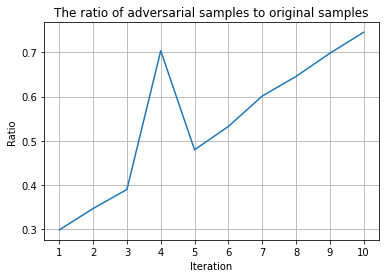

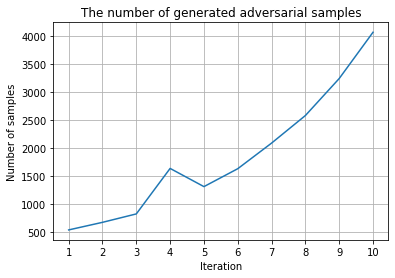

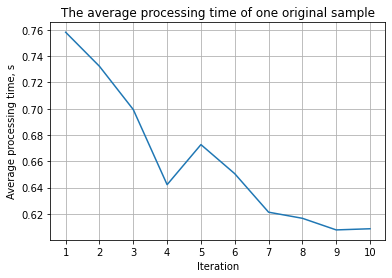

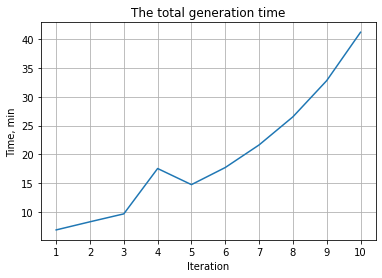

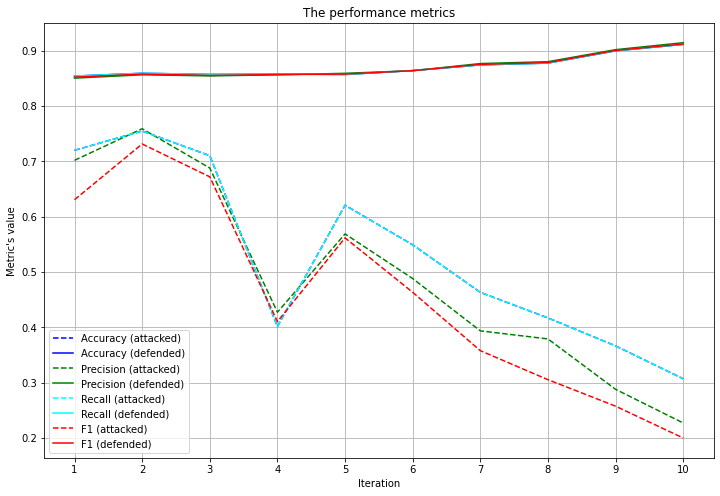

In [22]:
print_training_results(rf_results)
show_plots(rf_results)

From these results, we can see the following:
* The performance metrics degrade after the attack. Adversarial training after the attack effectively defends the model, restoring the metrics back. But the model remains vulnerable to repeated attacks afterwards: the defence works only against those generated adversarial samples that we correctly labeled and then added to the dataset. New iteration of the attack may still produce effective adversarial samples.
* The dataset expands on each iteration, which may cause the increase of the number of generated adversarial samples, but the ratio of adversarial samples to original samples also increases. 
* The average processing time of one original sample by generation algorithm decreases and the total generation time increases.

We may conclude here that adversarial training did not increase the robustness of the original Random Forest model against repeated HSJA attacks.

## Experiment No. 2: Decision Tree + HSJA

The aim of this experiment is to try to explain the results of the previous experiment, namely why the new iteration of the attack may still produce effective adversarial samples. For better interpretability, we use a Decision Tree model instead of a Random Forest model. On each iteration step, we display the decision tree after adversarial training, so we can observe the influence of adversarial training on the tree in progress.

### Data preprocessing

We use only the first five features, so that the visualization of decision trees is more easily understandable.

In [23]:
webattack_features = webattack_features[:5]

Separate our dataset into feature vectors and labels.

In [24]:
y = df['Label'].values
X = df[webattack_features].values

print(X.shape, y.shape)

(7267, 5) (7267,)


### Training the initial Decision Tree model

Split the dataset into train and test sets.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42)

Create and fit DecisionTreeClassifier.

In [26]:
model_type = 'DT'
model = Classifier(model_type)
model.fit(X=X_train, y=y_train)

DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=5)

Save this trained model for repeatability.

In [27]:
model.save_model(f'model_{model_type}_init.sav')

Load the trained model.

In [28]:
model.load_model(f'model_{model_type}_init.sav')

Get the Decision Tree model's evaluation metrics for the test data.

In [29]:
y_pred = model.predict(X_test)
y_pred.shape

(1817,)

In [30]:
initial_matrix = confusion_matrix(y_test, y_pred)
initial_matrix

array([[1255,    0,   10,    0],
       [  11,    0,  146,    0],
       [  45,    0,  345,    0],
       [   5,    0,    0,    0]])

In [31]:
print(get_metrics(y_test, y_pred))

{'Accuracy': 0.8805723720418271, 'Precision': 0.8117374001180049, 'Recall': 0.8805723720418271, 'F1': 0.843270046404932}


Show the initial decision tree.

|--- Fwd IAT Min <= 580.50
|   |--- class: 0
|--- Fwd IAT Min >  580.50
|   |--- Average Packet Size <= 0.60
|   |   |--- Fwd IAT Min <= 3249.00
|   |   |   |--- class: 2
|   |   |--- Fwd IAT Min >  3249.00
|   |   |   |--- class: 0
|   |--- Average Packet Size >  0.60
|   |   |--- Fwd IAT Min <= 1065.00
|   |   |   |--- class: 2
|   |   |--- Fwd IAT Min >  1065.00
|   |   |   |--- class: 0



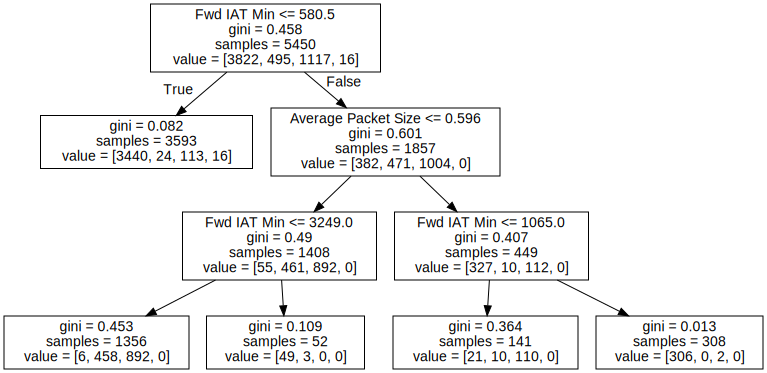

In [32]:
model.display_tree(features=webattack_features)

### Iterative adversarial training with Decision Tree models and the HSJA attack

Perform adversarial training on the initial Decision Tree model for the given number of iterations.

HopSkipJump:   0%|          | 0/1817 [00:00<?, ?it/s]

DT after adversarial training (iteration 1):
|--- Fwd IAT Min <= 533.00
|   |--- Average Packet Size <= 1.00
|   |   |--- class: 0
|   |--- Average Packet Size >  1.00
|   |   |--- class: 0
|--- Fwd IAT Min >  533.00
|   |--- Fwd IAT Min <= 2123.00
|   |   |--- Flow Bytes/s <= 0.00
|   |   |   |--- class: 2
|   |   |--- Flow Bytes/s >  0.00
|   |   |   |--- class: 2
|   |--- Fwd IAT Min >  2123.00
|   |   |--- class: 0



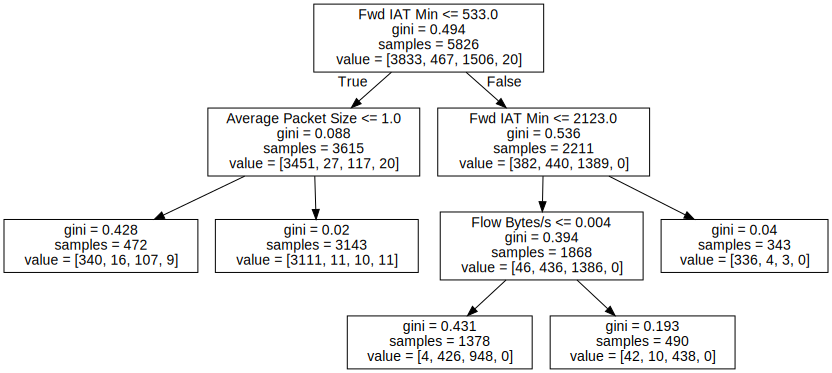

HopSkipJump:   0%|          | 0/1942 [00:00<?, ?it/s]

DT after adversarial training (iteration 2):
|--- Fwd IAT Min <= 493.00
|   |--- class: 0
|--- Fwd IAT Min >  493.00
|   |--- Max Packet Length <= 6.00
|   |   |--- Fwd IAT Min <= 3249.00
|   |   |   |--- Fwd Packet Length Mean <= 0.00
|   |   |   |   |--- class: 2
|   |   |   |--- Fwd Packet Length Mean >  0.00
|   |   |   |   |--- class: 2
|   |   |--- Fwd IAT Min >  3249.00
|   |   |   |--- class: 0
|   |--- Max Packet Length >  6.00
|   |   |--- class: 2



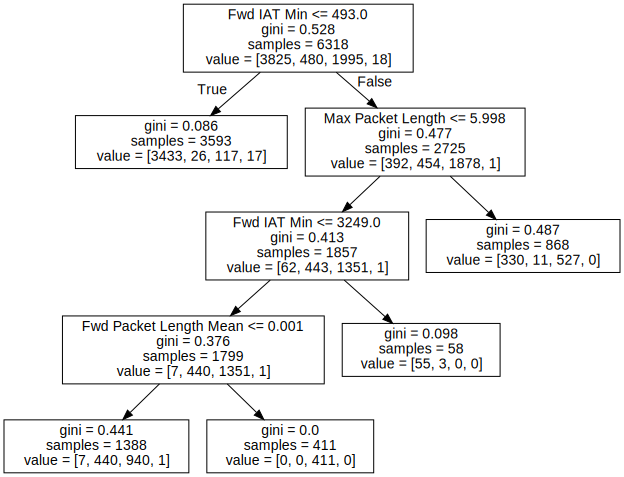

HopSkipJump:   0%|          | 0/2106 [00:00<?, ?it/s]

DT after adversarial training (iteration 3):
|--- Flow Bytes/s <= 38.97
|   |--- Fwd IAT Min <= 577.05
|   |   |--- class: 0
|   |--- Fwd IAT Min >  577.05
|   |   |--- Fwd IAT Min <= 2469.56
|   |   |   |--- class: 2
|   |   |--- Fwd IAT Min >  2469.56
|   |   |   |--- class: 0
|--- Flow Bytes/s >  38.97
|   |--- Fwd IAT Min <= 651.00
|   |   |--- class: 0
|   |--- Fwd IAT Min >  651.00
|   |   |--- class: 2



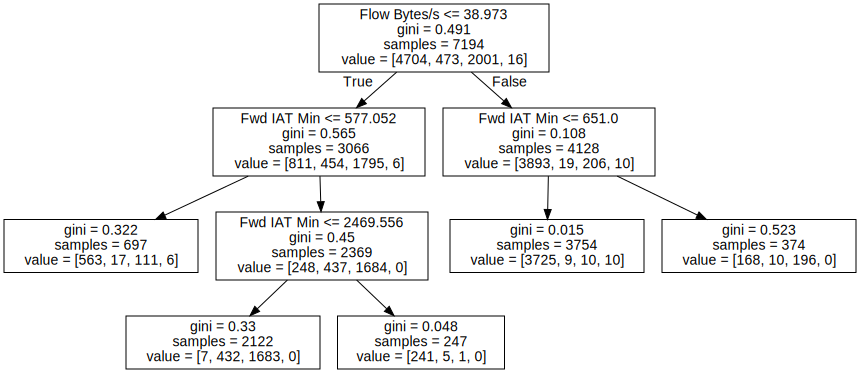

HopSkipJump:   0%|          | 0/2399 [00:00<?, ?it/s]

DT after adversarial training (iteration 4):
|--- Fwd IAT Min <= 746.63
|   |--- Flow Bytes/s <= 0.03
|   |   |--- Fwd IAT Min <= 660.72
|   |   |   |--- class: 0
|   |   |--- Fwd IAT Min >  660.72
|   |   |   |--- class: 2
|   |--- Flow Bytes/s >  0.03
|   |   |--- class: 0
|--- Fwd IAT Min >  746.63
|   |--- Max Packet Length <= 36.63
|   |   |--- class: 2
|   |--- Max Packet Length >  36.63
|   |   |--- class: 0



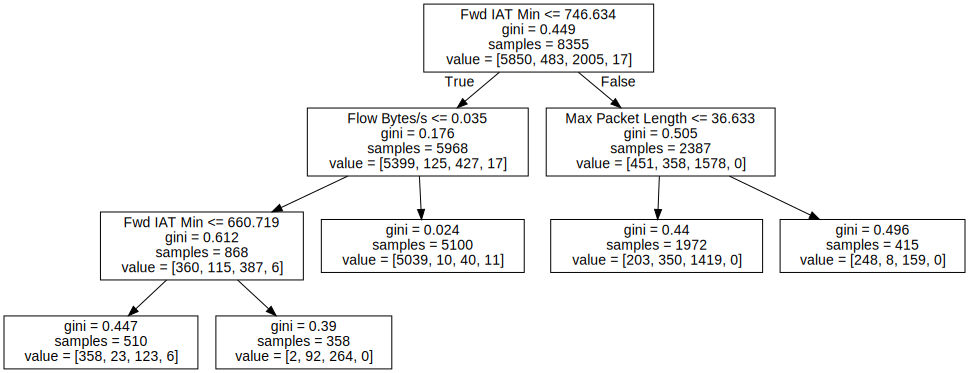

HopSkipJump:   0%|          | 0/2786 [00:00<?, ?it/s]

DT after adversarial training (iteration 5):
|--- Fwd IAT Min <= 746.35
|   |--- Max Packet Length <= 0.01
|   |   |--- Fwd IAT Min <= 584.87
|   |   |   |--- class: 0
|   |   |--- Fwd IAT Min >  584.87
|   |   |   |--- class: 2
|   |--- Max Packet Length >  0.01
|   |   |--- class: 0
|--- Fwd IAT Min >  746.35
|   |--- Max Packet Length <= 44.59
|   |   |--- class: 2
|   |--- Max Packet Length >  44.59
|   |   |--- class: 0



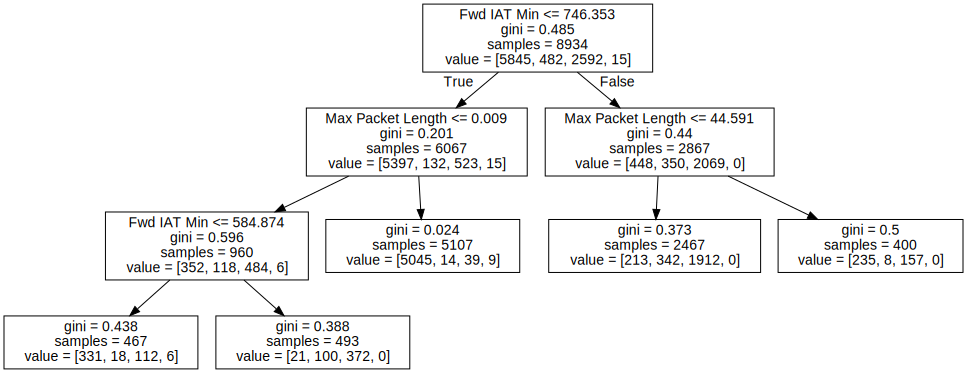

HopSkipJump:   0%|          | 0/2979 [00:00<?, ?it/s]

DT after adversarial training (iteration 6):
|--- Fwd IAT Min <= 746.35
|   |--- Average Packet Size <= 0.00
|   |   |--- class: 2
|   |--- Average Packet Size >  0.00
|   |   |--- class: 0
|--- Fwd IAT Min >  746.35
|   |--- Average Packet Size <= 52.68
|   |   |--- Max Packet Length <= 0.00
|   |   |   |--- class: 2
|   |   |--- Max Packet Length >  0.00
|   |   |   |--- class: 2
|   |--- Average Packet Size >  52.68
|   |   |--- class: 0



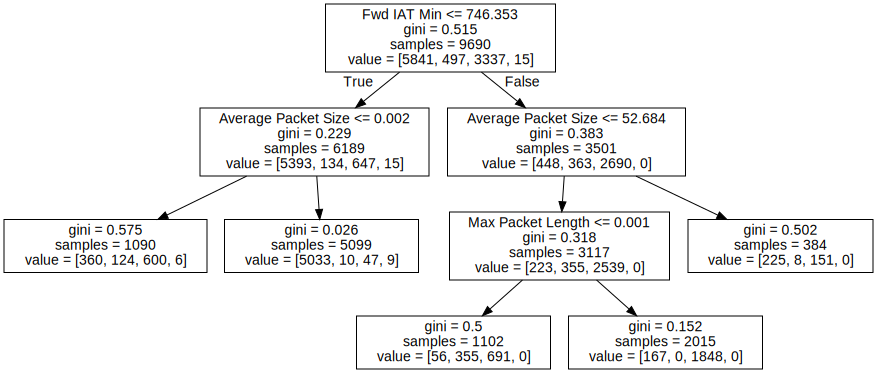

HopSkipJump:   0%|          | 0/3231 [00:00<?, ?it/s]

DT after adversarial training (iteration 7):
|--- Flow Bytes/s <= 40.48
|   |--- Max Packet Length <= 54.31
|   |   |--- Average Packet Size <= 0.00
|   |   |   |--- class: 2
|   |   |--- Average Packet Size >  0.00
|   |   |   |--- class: 2
|   |--- Max Packet Length >  54.31
|   |   |--- class: 0
|--- Flow Bytes/s >  40.48
|   |--- Fwd Packet Length Mean <= 149.48
|   |   |--- class: 0
|   |--- Fwd Packet Length Mean >  149.48
|   |   |--- class: 0



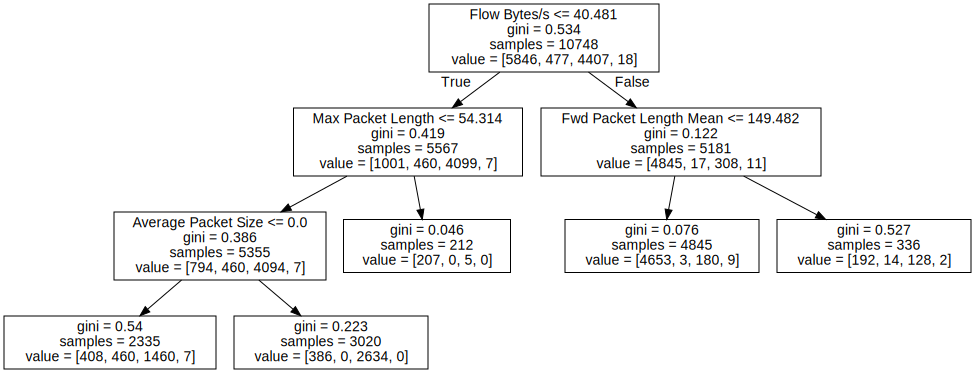

HopSkipJump:   0%|          | 0/3583 [00:00<?, ?it/s]

DT after adversarial training (iteration 8):
|--- Flow Bytes/s <= 48.89
|   |--- Fwd Packet Length Mean <= 26.64
|   |   |--- Fwd IAT Min <= 664.34
|   |   |   |--- class: 0
|   |   |--- Fwd IAT Min >  664.34
|   |   |   |--- Flow Bytes/s <= 0.00
|   |   |   |   |--- class: 2
|   |   |   |--- Flow Bytes/s >  0.00
|   |   |   |   |--- class: 2
|   |--- Fwd Packet Length Mean >  26.64
|   |   |--- class: 0
|--- Flow Bytes/s >  48.89
|   |--- class: 0



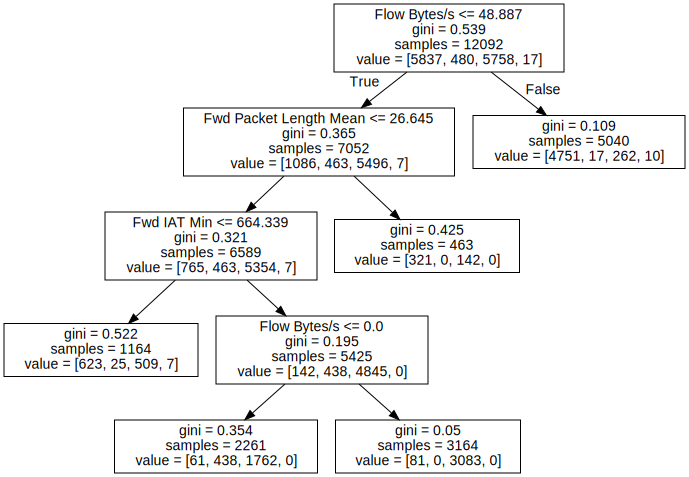

HopSkipJump:   0%|          | 0/4031 [00:00<?, ?it/s]

DT after adversarial training (iteration 9):
|--- Fwd Packet Length Mean <= 30.66
|   |--- Max Packet Length <= 62.92
|   |   |--- Max Packet Length <= 38.05
|   |   |   |--- Max Packet Length <= 6.00
|   |   |   |   |--- class: 2
|   |   |   |--- Max Packet Length >  6.00
|   |   |   |   |--- class: 0
|   |   |--- Max Packet Length >  38.05
|   |   |   |--- class: 2
|   |--- Max Packet Length >  62.92
|   |   |--- class: 0
|--- Fwd Packet Length Mean >  30.66
|   |--- class: 0



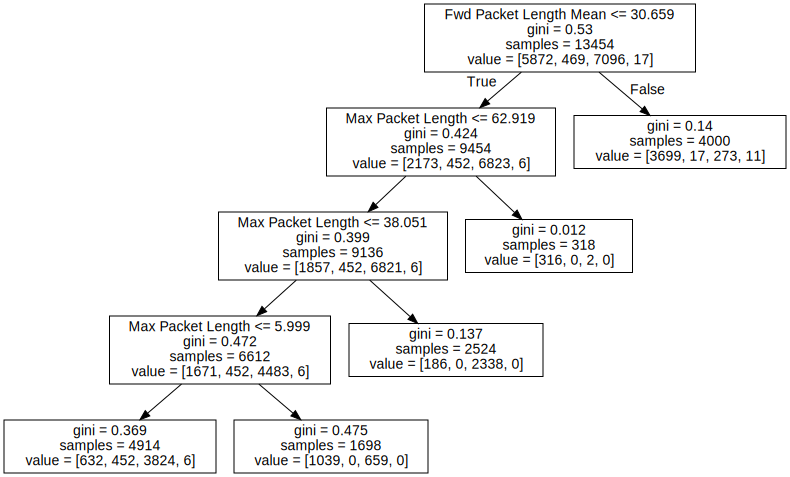

HopSkipJump:   0%|          | 0/4485 [00:00<?, ?it/s]

DT after adversarial training (iteration 10):
|--- Flow Bytes/s <= 56.09
|   |--- Fwd Packet Length Mean <= 39.13
|   |   |--- Average Packet Size <= 0.00
|   |   |   |--- Max Packet Length <= 0.00
|   |   |   |   |--- class: 2
|   |   |   |--- Max Packet Length >  0.00
|   |   |   |   |--- class: 2
|   |   |--- Average Packet Size >  0.00
|   |   |   |--- class: 2
|   |--- Fwd Packet Length Mean >  39.13
|   |   |--- class: 0
|--- Flow Bytes/s >  56.09
|   |--- class: 0



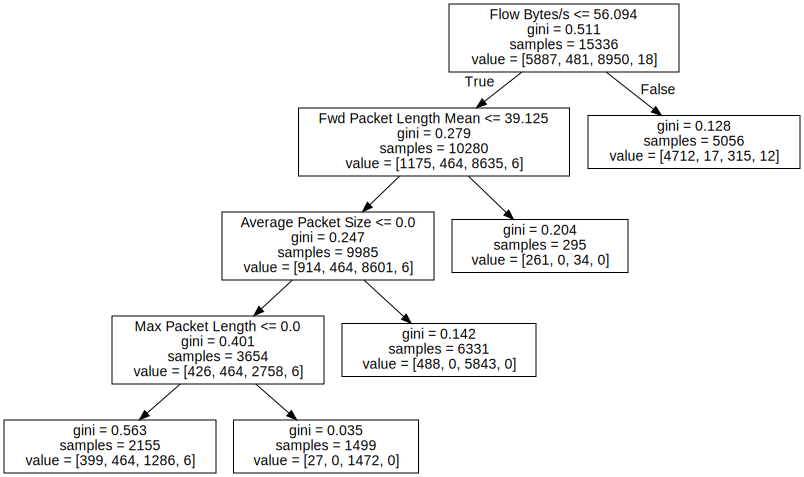

In [33]:
dt_iterations = 10
dt_results = adversarial_training(
    model, X, y, X_test, y_test, iterations=dt_iterations)

Let us consider the decision trees for the 4th and the 5th iterations.

After the defence, the decision boundary at the node "Fwd IAT Min" decreased from 660.719 to 584.874. For example, if an effective adversarial sample has the "Fwd IAT Min" feature near the old boundary 660.719 and the next iteration of the defence moves the decision boundary, then this sample ceases to be effective, because now the model can correctly classify the sample.

However, it is clear that, in the same way, the new iteration of the attack can find new adversarial samples (that was not previously seen by the model at the training phase) near the new boundary (584.874).

Now, show the rest of the experiment's results.


====ITERATION NO. 1====

Before adversarial training: 7267 samples in the dataset, 1817 samples in the test set.
Generated 501 adversarial samples from 1817 original samples.
Generation time:  45.770673751831055
After adversarial training: 7768 samples in the dataset, 1942 samples in the test set.

==Example of a sample==
Sample No. 6 of the original testing set: [[   0.    0.    0. 2946.    0.]]
Model prediction for the original sample:  2
Adversarial sample from the sample No. 6: [[6.8169272e-01 1.0046563e-03 9.2894295e-03 2.9460022e+03 2.2613760e-03]]
Model prediction for the adversarial sample:  0

==Results before the adversarial training==
Confusion matrix:
 [[1265    0    0    0]
 [ 157    0    0    0]
 [ 390    0    0    0]
 [   5    0    0    0]]
Evaluation metrics:
 {'Accuracy': 0.6962025316455697, 'Precision': 0.4846979650697004, 'Recall': 0.6962025316455697, 'F1': 0.5715095409030795}

==Results after the adversarial training==
Confusion matrix:
 [[1239    0   15    0]
 [  

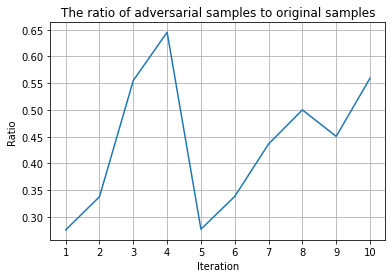

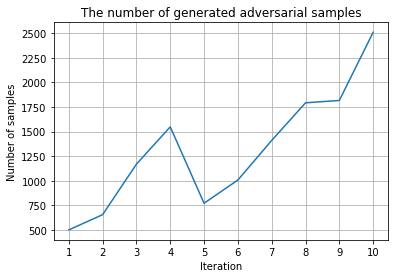

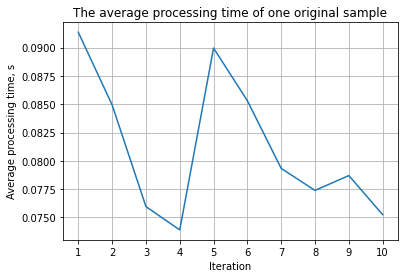

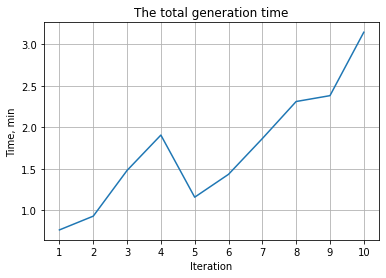

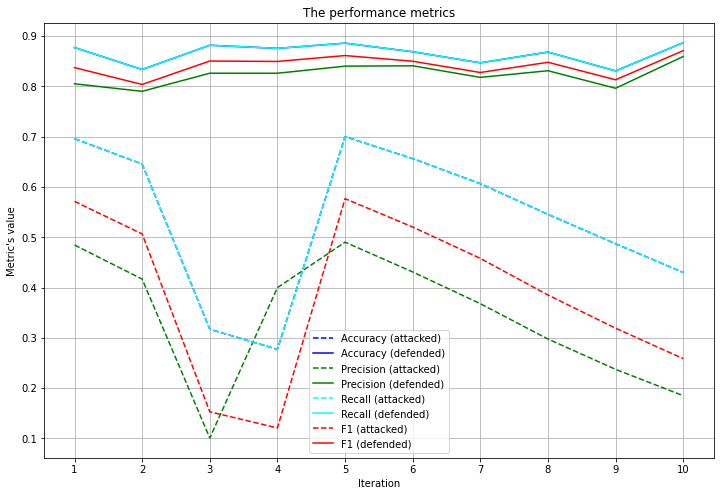

In [34]:
print_training_results(dt_results)
show_plots(dt_results)

As we can see, the results of the second experiment are similar to the results of the first experiment.

Finally, we may conclude that adversarial training does not guarantee an improvement of the robustness against an adversarial evasion attack: it can defend against already generated adversarial samples, but in the general case, a new iteration of the attack may still produce new and effective adversarial samples.